## Objective

This notebook aims to demonstrate the best practices of detecting fraudulent transactions for credit cards. It will contain steps for data cleaning, feature engineering, data preprocessing, model development and evaluation.

Modelling approach adopted largely from: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html

## Background

While there are no definite taxonomy on credit card fraud types, there are more common patterns that happen. These are: 
1) **card-present frauds**: physical cards are needed and transactions happen at Point-of-Sale or ATMs;frauds due to stolen, lost, counterfieted cards or cards not received.
2) **card-not-present frauds**: payments performed on the internet by phone or email; frauds due to illegally obtained credentials (card number, expiration date, security code and personal billing information) from data breaches, phishing, scam text or calls.

In Europe, the majority (69% to 79%) of card fraud value comes from card-not-present frauds.

In order to detect fraud cases, sophisticated credit card fraud detection system has been developed. The Machine Learning Group (Université Libre de Bruxelles - ULB) ([link](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_2_Background/FDS.html)) has made a convenient representation here: 
<img src="../images/fraud_detection_system.png" alt="Drawing" style="width: 500px;"/>
<br>
The predictive model that is being developed would fit into fraud detection system as the Data Driven Model component highlighted in the red box.

## Challenges
There are challenges for predicting credit card frauds. The Machine Learning Group (Université Libre de Bruxelles - ULB) ([link](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_2_Background/MachineLearningForFraudDetection.html)) has listed some below:
1) **Class imbalance**: Usually transactional data contains much more legitimate ones than fraud (<1%). Most learning algos do not handle imbalances well, so need to do additional strategies like sampling or loss weighting.
2) **Concept drift**: Transaction and fraud patterns changes over time and fraudsters develop new techniques.
3) **Near real-time requirements**: Classification times as low as tens of milliseconds may be required.
4) **Sequential modeling**: Each terminal and/or customers would generate data sequentially with its own unique characteristics. Models need to be able to account for these.
5) **Performance measures**: Accuracy and/or AUROC not sufficient. Other metrics such as F-1 Score, Recall, Precision and Area under the PR Curve could be more suitable.

# Dataset

For this exercise, data is extracted from Kaggle ([link](https://www.kaggle.com/datasets/dermisfit/fraud-transactions-dataset?resource=download)) and has the following columns:

1) trans_date_trans_time: The date and time of the transaction.
2) cc_num: credit card number.
3) merchant: Merchant who was getting paid.
4) category: In what area does that merchant deal.
5) amt: Amount of money in American Dollars.
6) first: first name of the card holder.
7) last: last name of the card holder.
8) gender: Gender of the cardholder.Just male and female!
9) street: Street of card holder residence
10) city: city of card holder residence
11) state: state of card holder residence
12) zip: ZIP code of card holder residence
13) lat: latitude of card holder
14) long: longitude of card holder
15) city_pop: Population of the city
16) job: trade of the card holder
17) dob: Date of birth of the card holder
18) trans_num: Transaction ID
19) unix_time: Unix time which is the time calculated since 1970 to today.
20) merch_lat: latitude of the merchant
21) merch_long: longitude of the merchant
22) is_fraud: Whether the transaction is fraud (1) or not (0)



## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [135]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from geopy.distance import geodesic 

In [3]:
SEED=99

## Credit Card Fraud Dataset

In [109]:
df_transactions_raw = pd.read_csv("../data/fraudTrain.csv", index_col=0)
df_transactions_raw.info()

/home/aznor/miniconda3/envs/fraud/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [111]:
def basic_clean(df):
    df_final = df.copy()
    df_final["trans_date_trans_time"] = pd.to_datetime(df_final["trans_date_trans_time"])
    df_final["cc_num"] = df_final["cc_num"].astype("str")
    df_final["zip"] = df_final["zip"].astype("str")
    df_final["dob"] = pd.to_datetime(df_final["dob"],format="%Y-%m-%d")
    df_final = df_final.sort_values(by=["trans_date_trans_time"])
    
    return df_final

print(basic_clean(df_transactions_raw.head(1)).iloc[0], end="\n\n")
print(basic_clean(df_transactions_raw.head(1)).info())

trans_date_trans_time                 2019-01-01 00:00:18
cc_num                                   2703186189652095
merchant                       fraud_Rippin, Kub and Mann
category                                         misc_net
amt                                                  4.97
first                                            Jennifer
last                                                Banks
gender                                                  F
street                                     561 Perry Cove
city                                       Moravian Falls
state                                                  NC
zip                                                 28654
lat                                               36.0788
long                                             -81.1781
city_pop                                             3495
job                             Psychologist, counselling
dob                                   1988-03-09 00:00:00
trans_num     

In [112]:
df_transactions_clean = basic_clean(df_transactions_raw)

## Conduct Basic EDA

In [113]:
neg, pos = np.bincount(df_transactions_clean["is_fraud"])
print(f"Total Training Data: {neg+pos}\nFraudulent Labels: {pos} ({round(100*(pos/(pos+neg)), 2)}% of Total)")

Total Training Data: 1296675
Fraudulent Labels: 7506 (0.58% of Total)


In [114]:
print("Date range is between: {0} to {1}".format(
    df_transactions_clean["trans_date_trans_time"].min(),
    df_transactions_clean["trans_date_trans_time"].max()
))

Date range is between: 2019-01-01 00:00:18 to 2020-06-21 12:13:37


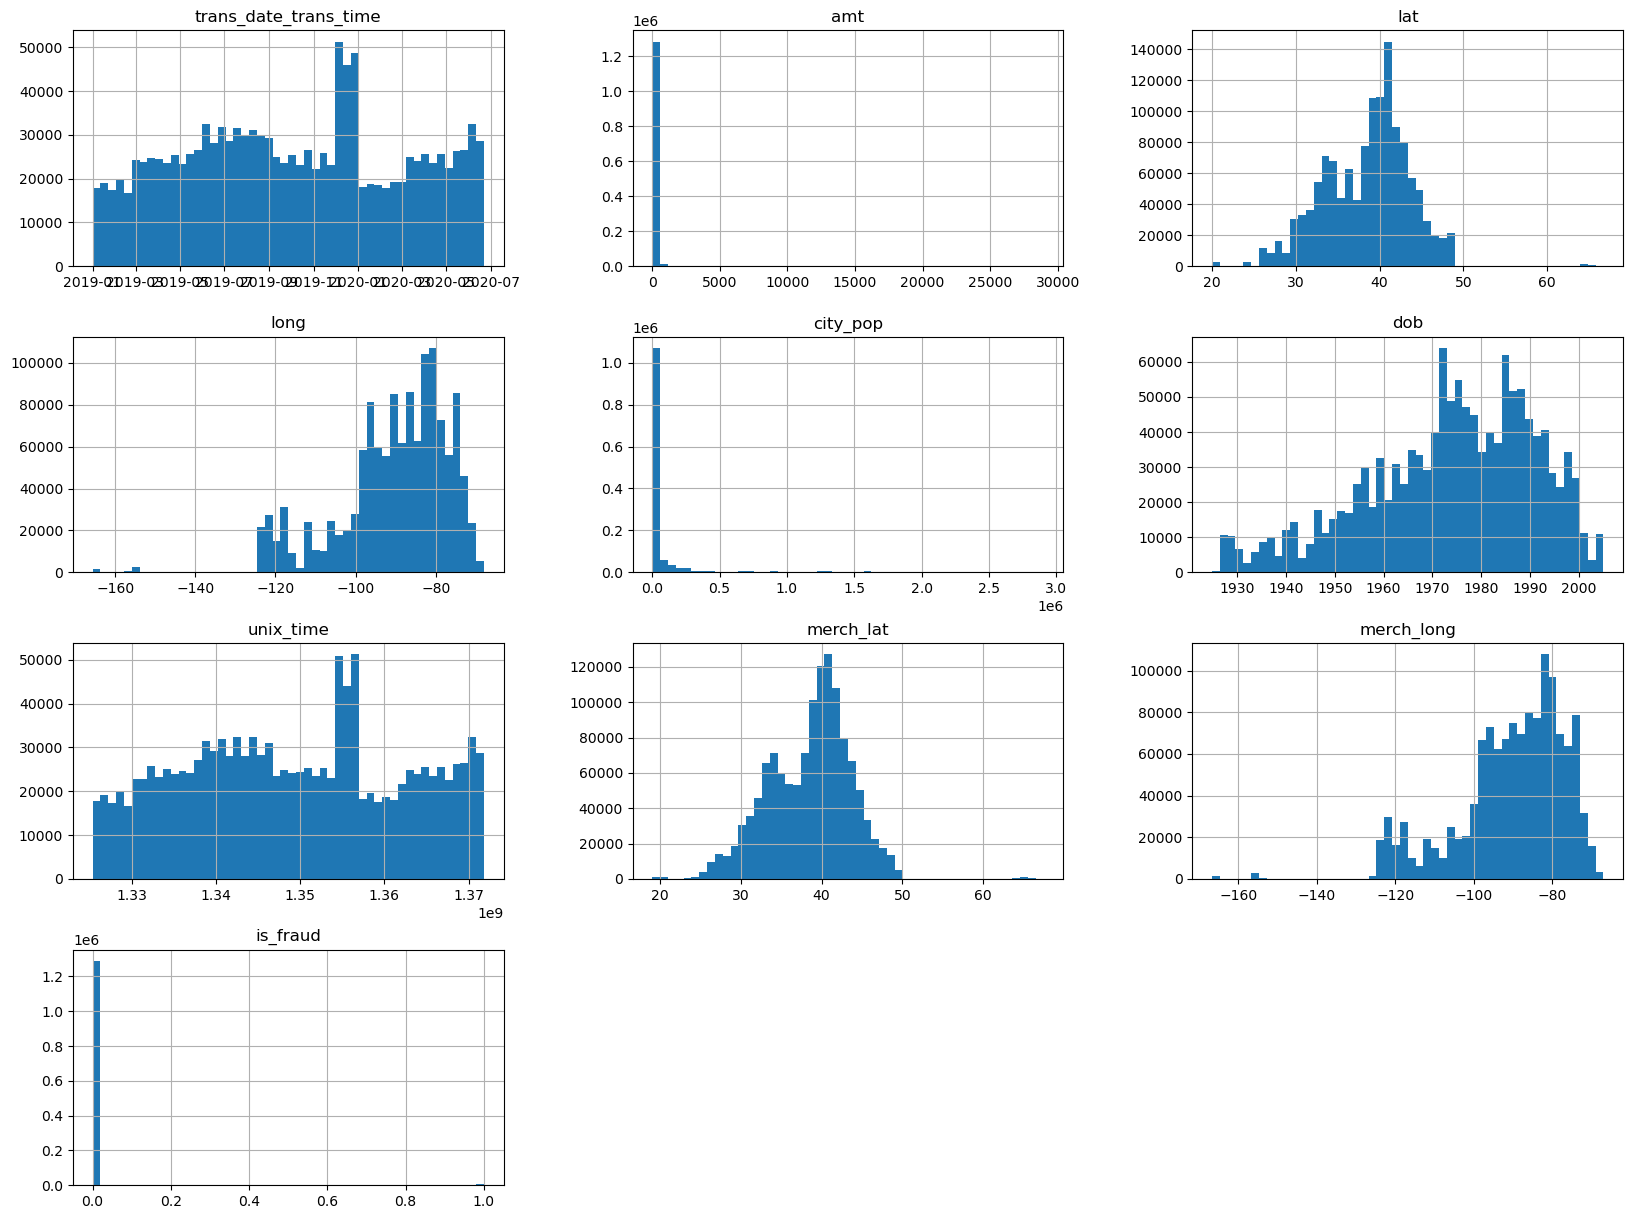

In [115]:
# examine the distribution of each numerical variable
%matplotlib inline
df_transactions_clean.hist(bins=50, figsize=(20,15))
plt.show()

In [116]:
# examine the labels and distribution of the categorical variable 
cat_cols = df_transactions_clean.select_dtypes(include=['object']).columns
for col_name in cat_cols:
    print(df_transactions_clean[col_name].value_counts(dropna=False, normalize=True), "\n\n")

571365235126           0.002408
4512828414983801773    0.002408
36722699017270         0.002405
213112402583773        0.002404
3545109339866548       0.002401
                         ...   
180097223252063        0.000005
4225628813173670       0.000005
501894933032           0.000005
4975457191020          0.000005
340187018810220        0.000005
Name: cc_num, Length: 983, dtype: float64 


fraud_Kilback LLC                       0.003396
fraud_Cormier LLC                       0.002814
fraud_Schumm PLC                        0.002803
fraud_Kuhn LLC                          0.002707
fraud_Boyer PLC                         0.002694
                                          ...   
fraud_Douglas, DuBuque and McKenzie     0.000598
fraud_Treutel-King                      0.000598
fraud_Medhurst, Labadie and Gottlieb    0.000585
fraud_Reichert-Weissnat                 0.000581
fraud_Hahn, Douglas and Schowalter      0.000561
Name: merchant, Length: 693, dtype: float64 


gas_transport    

In [117]:
# Examine cross-correlation between numerical variable and categorical variable of concern
df_temp = pd.concat(
    [
        df_transactions_clean[df_transactions_clean["is_fraud"] == 0],
        df_transactions_clean[df_transactions_clean["is_fraud"] == 1],
    ]
)

fig = px.histogram(
    df_temp.sample(n=10000),
    title="Fraud for different amounts (n=10,000 random sample)",
    x="amt",
    color="is_fraud",
    marginal="box",
)
fig.update_traces(opacity=0.75)
fig.update_layout(barmode="overlay")
fig.show()

## Feature Engineering

In [201]:
# Set a start data from when to start training the model. Start date has to be a few months 
# after the first date of data available in the dataset to allow for some customer features
# to be calculated
START_DATE = dt.datetime(*(2019, 1, 1))

In [202]:
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="merchant"):
    
    terminal_transactions=terminal_transactions.sort_values('trans_date_trans_time')
    
    terminal_transactions.index=terminal_transactions.trans_date_trans_time
    
    NB_FRAUD_DELAY=terminal_transactions['is_fraud'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['is_fraud'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['is_fraud'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['is_fraud'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.trans_num
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions


def prepare_x(df, start_date):
    df_final = df.copy()
    
    # Add date fields from start date
    df_final["trans_date_trans_time_seconds"] = [x.total_seconds() for x in (df_final["trans_date_trans_time"] - START_DATE)]
    df_final["trans_date_trans_time_days"] = [x.days for x in (df_final["trans_date_trans_time"] - START_DATE)]
    
    # Create features
    df_final["hour_of_day"] = df_final["trans_date_trans_time"].dt.strftime('%H')
    df_final["day_of_week"] = df_final["trans_date_trans_time"].dt.strftime('%w')
    df_final["age_months"] = ((df_final["trans_date_trans_time"] - df_final["dob"])/np.timedelta64(1, 'M')).astype(int)
    df_final["cc_num_transactions_1day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").count())["amt"]
    df_final["cc_num_transactions_7day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").count())["amt"]
    df_final["cc_num_transactions_30day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").count())["amt"]
    df_final["cc_avg_amt_1day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").mean())["amt"]
    df_final["cc_avg_amt_7day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").mean())["amt"]
    df_final["cc_avg_amt_30day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").mean())["amt"]
    df_final["merchant_num_transactions_1day"] = df_final.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").count())["amt"]
    df_final["merchant_num_transactions_7day"] = df_final.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").count())["amt"]
    df_final["merchant_num_transactions_30day"] = df.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").count())["amt"]
    df_final["merchant_avg_amt_1day"] = df_final.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").mean())["amt"]
    df_final["merchant_avg_amt_7day"] = df_final.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").mean())["amt"]
    df_final["merchant_avg_amt_30day"] = df_final.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").mean())["amt"]
    df_final["holder_merchant_geodist_km"] = [geodesic((x[0], x[1]), (x[2], x[3])).km for x in zip(df_final["lat"], df_final["long"], df_final["merch_lat"], df_final["merch_long"])]
    
    # Get risk scores of merchants
    df_final=df_final.groupby('merchant').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="merchant"))
    df_final=df_final.sort_values('trans_date_trans_time').reset_index(drop=True)
    
    return df_final
    

print(prepare_x(df_transactions_clean.head(1), START_DATE).iloc[0], end="\n\n")
print(prepare_x(df_transactions_clean.head(1), START_DATE).info())

trans_date_trans_time                           2019-01-01 00:00:18
cc_num                                             2703186189652095
merchant                                 fraud_Rippin, Kub and Mann
category                                                   misc_net
amt                                                            4.97
first                                                      Jennifer
last                                                          Banks
gender                                                            F
street                                               561 Perry Cove
city                                                 Moravian Falls
state                                                            NC
zip                                                           28654
lat                                                         36.0788
long                                                       -81.1781
city_pop                                        

In [203]:
df_final = prepare_x(df_transactions_clean, START_DATE)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 46 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   trans_date_trans_time            1296675 non-null  datetime64[ns]
 1   cc_num                           1296675 non-null  object        
 2   merchant                         1296675 non-null  object        
 3   category                         1296675 non-null  object        
 4   amt                              1296675 non-null  float64       
 5   first                            1296675 non-null  object        
 6   last                             1296675 non-null  object        
 7   gender                           1296675 non-null  object        
 8   street                           1296675 non-null  object        
 9   city                             1296675 non-null  object        
 10  state                         

In [204]:
df_final.trans_date_trans_time_days.max()+1

538

## Save to Local File System

In [205]:
DIR_OUTPUT = "../data/transformed"

In [206]:
if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = dt.datetime.strptime("2019-01-01", "%Y-%m-%d")

for day in range(df_final.trans_date_trans_time_days.max()+1):
    
    transactions_day = df_final[df_final.trans_date_trans_time_days==day].sort_values('trans_date_trans_time_seconds')
    
    date = start_date + dt.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    transactions_day.to_pickle(DIR_OUTPUT+"/"+filename_output)

## Baseline Fraud Detection System

In [207]:
DIR_INPUT = "../data/transformed"

In [208]:
# Use four weeks for training, one week of delay and one week for testing
BEGIN_DATE = "2019-03-06" 
END_DATE = "2019-04-17"


def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('trans_num')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    
    return df_final

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.is_fraud.sum()))


Load  files
CPU times: user 410 ms, sys: 15.9 ms, total: 426 ms
Wall time: 424 ms
96596 transactions loaded, containing 631 fraudulent transactions


In [209]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=28,delta_delay=7,delta_test=7):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.trans_date_trans_time>=start_date_training) &
                               (transactions_df.trans_date_trans_time<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be compromised after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known defrauded customers from the training set
    known_defrauded_customers = set(train_df[train_df.is_fraud==1].cc_num)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.trans_date_trans_time_days.min()
    
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.trans_date_trans_time_days==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        test_df_day_delay_period = transactions_df[transactions_df.trans_date_trans_time_days==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.is_fraud==1].cc_num)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)
        
        test_df_day = test_df_day[~test_df_day.cc_num.isin(known_defrauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('trans_num')
    test_df=test_df.sort_values('trans_num')
    
    return (train_df, test_df)

In [210]:
start_date_training = datetime.datetime.strptime(BEGIN_DATE, "%Y-%m-%d")
end_date_training = start_date_training+datetime.timedelta(days=28-1)
start_date_test = start_date_training+datetime.timedelta(days=28+7)
end_date_test = start_date_training+datetime.timedelta(days=28+7+7-1)

print(start_date_training)
print(end_date_training)
print(start_date_test)
print(end_date_test)

2019-03-06 00:00:00
2019-04-02 00:00:00
2019-04-10 00:00:00
2019-04-16 00:00:00


In [219]:
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=28,delta_delay=7,delta_test=7)

In [220]:
train_df.shape

(63210, 46)

In [221]:
train_df[train_df.is_fraud==1].shape

(449, 46)

In [222]:
test_df.shape

(15051, 46)

In [223]:
test_df[test_df.is_fraud==1].shape

(78, 46)

## Model Training

In [225]:
transactions_df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_date_trans_time_seconds',
       'trans_date_trans_time_days', 'hour_of_day', 'day_of_week',
       'age_months', 'cc_num_transactions_1day', 'cc_num_transactions_7day',
       'cc_num_transactions_30day', 'cc_avg_amt_1day', 'cc_avg_amt_7day',
       'cc_avg_amt_30day', 'merchant_num_transactions_1day',
       'merchant_num_transactions_7day', 'merchant_num_transactions_30day',
       'merchant_avg_amt_1day', 'merchant_avg_amt_7day',
       'merchant_avg_amt_30day', 'holder_merchant_geodist_km',
       'merchant_NB_TX_1DAY_WINDOW', 'merchant_RISK_1DAY_WINDOW',
       'merchant_NB_TX_7DAY_WINDOW', 'merchant_RISK_7DAY_WINDOW',
       'merchant_NB_TX_30DAY_WINDOW', 'merchant_RISK_30DAY_WINDOW'],
      dtype='object')

In [227]:
target = "is_fraud"

In [249]:
input_features = [
    "amt", "city_pop", "hour_of_day", "day_of_week", "age_months", "cc_num_transactions_1day", "cc_num_transactions_7day",
    "cc_num_transactions_30day", "cc_avg_amt_1day", "cc_avg_amt_7day", "cc_avg_amt_30day",
    "merchant_num_transactions_1day", "merchant_num_transactions_7day", "merchant_num_transactions_30day",
    "merchant_avg_amt_1day", "merchant_avg_amt_7day", "merchant_avg_amt_30day", "holder_merchant_geodist_km",
    "merchant_NB_TX_1DAY_WINDOW", "merchant_RISK_1DAY_WINDOW", "merchant_NB_TX_7DAY_WINDOW", 
    "merchant_RISK_7DAY_WINDOW", "merchant_NB_TX_30DAY_WINDOW", "merchant_RISK_30DAY_WINDOW"
]

In [250]:
def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])
    
    return (train,test)

In [251]:
def fit_model_and_get_predictions(classifier, train_df, test_df, 
                                  input_features, output_feature="is_fraud",scale=True):

    # By default, scales input data
    if scale:
        (train_df, test_df)=scaleData(train_df,test_df,input_features)
    
    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

In [255]:
classifiers_dictionary={'Logistic regression': LogisticRegression(random_state=0), 
                        'Decision tree with depth of two':DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':DecisionTreeClassifier(random_state=0), 
                        'Random forest':RandomForestClassifier(random_state=0,n_jobs=-1),
                        'XGBoost':XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
    
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, 
                                                                                  input_features=input_features,
                                                                                output_feature=target)
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions


/home/aznor/miniconda3/envs/fraud/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[01:34:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [258]:
def card_precision_top_k_day(df_day,top_k):
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('cc_num').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
            
    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_compromised_cards=list(df_day_top_k[df_day_top_k.is_fraud==1].cc_num)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_compromised_cards) / top_k
    
    return list_detected_compromised_cards, card_precision_top_k

def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['trans_date_trans_time_days'].unique())
    list_days.sort()
    
    # At first, the list of detected compromised cards is empty
    list_detected_compromised_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['trans_date_trans_time_days']==day]
        df_day = df_day[['predictions', 'cc_num', 'is_fraud']]
        
        # Let us remove detected compromised cards from the set of daily transactions
        df_day = df_day[df_day.cc_num.isin(list_detected_compromised_cards)==False]
        
        nb_compromised_cards_per_day.append(len(df_day[df_day.is_fraud==1].cc_num.unique()))
        
        detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Let us update the list of detected compromised cards
        if remove_detected_compromised_cards:
            list_detected_compromised_cards.extend(detected_compromised_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='is_fraud', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
    
    for top_k in top_k_list:
    
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances

In [264]:
def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test',
                                            top_k_list=[100]):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        #predictions_df['predictions']=0.5 for a model randomly choosing 
        
        performances_model=performance_assessment(predictions_df, output_feature='is_fraud', 
                                                   prediction_feature='predictions', top_k_list=top_k_list)
        performances_model.index=[classifier_name]
        
        performances=performances.append(performances_model)
        
    return performances

In [262]:
# performances on test set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, test_df, 
                                                        type_set='test', 
                                                        top_k_list=[100])
df_performances

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.971,0.641,0.013
Decision tree with depth of two,0.838,0.420,0.013
Decision tree - unlimited depth,0.794,0.364,0.013
Random forest,0.970,0.872,0.013
XGBoost,0.995,0.918,0.013


## Summary of Baseline Models
- Model was able to learn some useful fraud patterns from the training data - AUROC on the test set is >0.5 for all classifiers. Boosting model provides the best performance - based on precision alone.
- Based on Card Precision@100, around 1% of the cards with the highest fraudulent scores were compromised, if one each day, 100 transactions are being investigated. This is double the percentage of fraud in the test set (0.5%)